# Inference on DYAMOND MCSs

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision

from id_selector import IDSelector
import dataset
import unet
import dl_stats

In [2]:
def Tb_to_OLR(Tb):
    # brightness temperature to olr
    a = 1.228
    b = -1.106e-3
    sigma = 5.67e-8  # W m^-2 K^-4
    OLR = ((((Tb * (2*b) + a)**2 - (a**2)) / (4*b))**4) * sigma
    return OLR


def OLR_to_TB(OLR):
    # olr to brightness temperature
    a = 1.228
    b = -1.106e-3
    sigma = 5.67e-8  # W m^-2 K^-4
    tf = (OLR/sigma)**0.25
    Tb = (-a + np.sqrt((a**2) + (4*b*tf)))/(2*b)
    return Tb

In [3]:
# generate class ids object using same settings as training
class_ids = IDSelector(
    main_path='/glade/derecho/scratch/molina/cesm_mcs/cesm_era5/',
    start_year=2004,
    end_year=2019,
    month_only=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    year_only=None,
    mcs_only=True,
    percent_train=0.7,
    percent_validate=0.1,
)

# here we generate the list of IDs by loading from a presaved dictionary
IDlist = class_ids.generate_IDarray(dict_freq='1H')

# here we shuffle and split the IDs into a testing and training set
train_IDs, valid_IDs, test_IDs = class_ids.generate_traintest_split(
    IDlist,
    seed=0,
)

starting ID generation...
ID generation complete.


In [5]:
# double check numbers match training
print(
    f"Training set contains {len(train_IDs)} total training MCSs."
)
print(
    f"Validation set contains {len(valid_IDs)} total training MCSs."
)
print(
    f"Testing set contains {len(test_IDs)} total training MCSs."
)

Training set contains 48747 total training MCSs.
Validation set contains 8124 total training MCSs.
Testing set contains 24375 total training MCSs.


In [6]:
# only using ttr for mcsmip protocol
variables = ["ttr"]

In [7]:
# use training generator to get norm statistics
training_generator = dataset.CustomDataset(
    list_IDs=train_IDs,
    path_dataID="/glade/derecho/scratch/molina/cesm_mcs/cesm_era5/dl_files/1H/",
    variable=variables,
    batch_size=32,
    dim=(121, 321),
    n_channels=len(variables),
    n_classes=2,
    shuffle=True,
    norm='zscore',
    transform=torchvision.transforms.RandomVerticalFlip(p=0.5),
)
train_load = DataLoader(
    training_generator,
    batch_size=1,
    shuffle=False,
    drop_last=False
)

In [8]:
# load pretrained model using unet class
net = unet.UNet(n_channels=len(variables), n_classes=2)
net.load_state_dict(
    torch.load(
        '/glade/derecho/scratch/molina/mcs_unet_model_1channel.pt',
        map_location=torch.device('cpu')
    )
)
# set unet to evaluation mode
net.eval()
# assign softmax for inference
m = nn.Softmax(dim=1)

In [9]:
# list of directories to make life a little easier
mcs_dir = '/glade/derecho/scratch/molina/MCSMIP/OLR_Precipitation_combined/'

# filename = 'olr_pcp_Summer_ARPEGE.nc'
# filename = 'olr_pcp_Summer_NICAM.nc'
# filename = 'olr_pcp_Summer_IFS.nc'
# filename = 'olr_pcp_Summer_SAM.nc'
# filename = 'olr_pcp_Summer_MPAS.nc'
# filename = 'olr_pcp_Summer_UM.nc'
# filename = 'olr_pcp_Summer_FV3.nc'
# filename = 'olr_pcp_Summer_SCREAMv1.nc'

filename = 'olr_pcp_Summer_OBS.nc'
# filename = 'olr_pcp_Winter_OBS.nc'
# filename = 'olr_pcp_Summer_OBSv7.nc'
# filename = 'olr_pcp_Winter_OBSv7.nc'

# filename = 'olr_pcp_Winter_ARPEGE.nc'
# filename = 'olr_pcp_Winter_NICAM.nc' (Dont do)
# filename = 'olr_pcp_Winter_IFS.nc'
# filename = 'olr_pcp_Winter_SAM.nc'
# filename = 'olr_pcp_Winter_MPAS.nc'
# filename = 'olr_pcp_Winter_UM.nc'
# filename = 'olr_pcp_Winter_SCREAM.nc'
# filename = 'olr_pcp_Winter_SCREAMv1.nc'
# filename = 'olr_pcp_Winter_GRIST.nc'
# filename = 'olr_pcp_Winter_ICON.nc'
# filename = 'olr_pcp_Winter_XSHiELD.nc'
# filename = 'olr_pcp_Winter_GEOS.nc'

In [32]:
# load dyamond data to detect mcss in
ds = xr.open_dataset(mcs_dir+filename)

In [33]:
# check what it looks like
ds

<xarray.Dataset>
Dimensions:        (time: 960, lat: 1200, lon: 3600)
Coordinates:
  * lat            (lat) float64 -59.95 -59.85 -59.75 ... 59.75 59.85 59.95
  * lon            (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.8 179.9
  * time           (time) datetime64[ns] 2016-08-01 ... 2016-09-09T23:00:00
Data variables:
    Tb             (time, lat, lon) float32 ...
    precipitation  (time, lat, lon) float32 ...
Attributes:
    Title:       Summer OBS OLR & precipitation
    phase:       Summer
    source:      OBS
    Created_on:  Sun Nov  5 10:44:01 2023

In [34]:
# if obs file, do this
ds = ds.assign(olr=Tb_to_OLR(ds['Tb']))
# replace nan with max olr (no mcs)
ds = ds.where(~np.isnan(ds['olr']), ds['olr'].max().values)

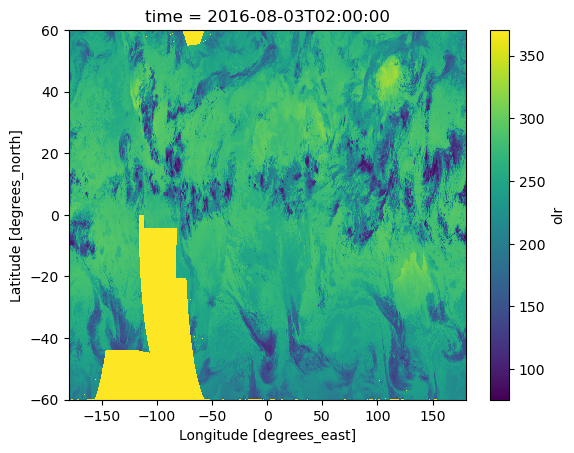

In [35]:
# double-checking file
ds['olr'].isel(time=50).plot()

In [36]:
# transpose dims to be same as training data, grab olr
ready_ds = ds['olr'].expand_dims(
    dim='channel').transpose('time', 'channel', 'lat', 'lon').values * 3600

In [51]:
# normalize the dyamond data using stats from training data (era5)
normed_ds = dl_stats.z_score(
    ready_ds,
    training_generator.stat_a,
    training_generator.stat_b
)
# change to a tensor
normed_ds_tf = torch.tensor(normed_ds)

In [53]:
# assign objects to add to saved file
lonarray = ds.coords["lon"].values
latarray = ds.coords["lat"].values
datearray = ds.coords["time"].values
savedir = f"/glade/derecho/scratch/molina/MCSMIP/mloutput/{ds.attrs['phase']}/{ds.attrs['source']}"

In [54]:
# just checking
savedir

'/glade/derecho/scratch/molina/MCSMIP/mloutput/Summer/OBS'

In [55]:
# loop thru dyamond data,
# detect mcss using unet,
# save detected mcss to netcdf file
for i in range(0, normed_ds.shape[0]):
    # inference
    pred_ds = net(
        torch.unsqueeze(normed_ds_tf[i, :, :, :], 0)
    )
    # softmax application
    pred_ds = m(
        pred_ds
    )
    # create xarray dataset
    ds_to_save = xr.Dataset(
        data_vars=dict(
            data=(["time", "class", "lat", "lon"], pred_ds.detach().numpy()),
        ),
        coords=dict(
            lon=(["lon"], lonarray),
            lat=(["lat"], latarray),
            # time=[pd.Timestamp(datearray[i])],
            time=[datearray[i]],
        ),
    )
    # save file
    ds_to_save.to_netcdf(
        f"{savedir}_{ds_to_save.time.dt.strftime('%Y%m%d%H').values[0]}.nc"
    )

In [4]:
# done! now do another dyamond file above or apply to idealized cases below!

### idealized cases

In [10]:
mcsdir = '/glade/derecho/scratch/molina/MCSMIP/idealized_cases/'
file1 = 'MCS-test-1_3-merging_1-splitting.nc'
file2 = 'MCS-test-3_3-merging_1-splitting_longer-isolation_single-overshoot.nc'
file3 = 'MCS-test-2_3-merging_1-splitting_longer-isolation.nc'
file4 = 'MCS-test-4_asynchronous-development.nc'

In [55]:
ds = xr.open_dataset(mcsdir+file4)

In [56]:
ds = ds.assign(olr=Tb_to_OLR(ds['Tb']))

In [57]:
ds

<xarray.Dataset>
Dimensions:  (time: 26, yc: 200, xc: 150)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 ... 2020-01-02T01:00:00
    lat      (yc, xc) float32 ...
    lon      (yc, xc) float32 ...
Dimensions without coordinates: yc, xc
Data variables:
    Tb       (time, yc, xc) float32 300.0 300.0 300.0 ... 300.0 300.0 300.0
    PR       (time, yc, xc) float32 ...
    olr      (time, yc, xc) float32 296.3 296.3 296.3 ... 296.3 296.3 296.3
Attributes:
    description:  Idealized MCS to test tracking algorithms
    author:       Andreas Prein
    email:        prein@ucar.edu

In [58]:
ready_ds = ds['olr'].expand_dims(
    dim='channel').transpose('time', 'channel', 'yc', 'xc').values * 3600

In [59]:
ready_ds.shape

(26, 1, 200, 150)

In [60]:
normed_ds = dl_stats.z_score(
    ready_ds,
    training_generator.stat_a,
    training_generator.stat_b
)

normed_ds_tf = torch.tensor(normed_ds)

In [61]:
lonarray = ds.coords["lon"].values
latarray = ds.coords["lat"].values
datearray = ds.coords["time"].values
savedir = f"/glade/derecho/scratch/molina/MCSMIP/mloutput/Idealized/Idealized4"

In [62]:
lonarray.shape

(200, 150)

In [63]:
pred_ds.shape

torch.Size([1, 2, 200, 150])

In [64]:
for i in range(0, normed_ds.shape[0]):

    pred_ds = net(torch.unsqueeze(normed_ds_tf[i, :, :, :], 0))
    pred_ds = m(pred_ds)

    ds_to_save = xr.Dataset(
        data_vars=dict(
            data=(["time", "class", "yc", "xc"], pred_ds.detach().numpy()),
        ),
        coords=dict(
            lon=(["yc", "xc"], lonarray),
            lat=(["yc", "xc"], latarray),
            # time=[pd.Timestamp(datearray[i])],
            time=[datearray[i]],
        ),
    )

    ds_to_save.to_netcdf(
        f"{savedir}_{ds_to_save.time.dt.strftime('%Y%m%d%H').values[0]}.nc"
    )